In [1]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

df = pd.read_csv(Path("/Users/arstanbek/Projects/fibrosis/BiTis/datasets") / "tissue_dataset.csv")

# Convert string representation of numpy arrays to numpy arrays:
df['Tissue Matrix'] = df['Tissue Matrix'].apply(
    lambda x: np.array(ast.literal_eval(x))
)
df['Tissue size'] = df['Tissue size'].apply(
    lambda x: ast.literal_eval(x)
)

# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'].between(0.3, 0.35)) &
                 (df['Elongation'] > 1.5)]

print(filtered_df.shape)
texture = filtered_df["Tissue Matrix"].iloc[2]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2).astype(np.float32)

(9, 8)


100%|██████████| 40000/40000 [00:16<00:00, 2398.50it/s]


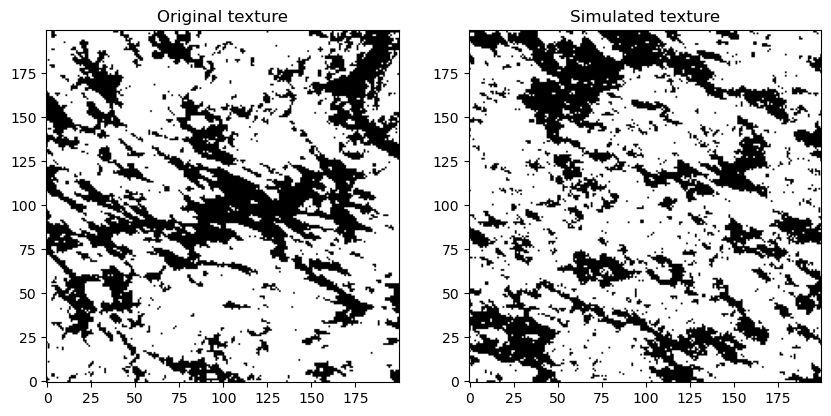

In [51]:
import bitis as bt


texture = filtered_df["Tissue Matrix"].iloc[1]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2).astype(np.float32)

texture_ = texture[:, :].copy()
simulation_tex = np.zeros_like(texture_)

simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=20,
                                 max_template_size=50,
                                 min_template_size=5,
                                 num_of_candidates=3,
                                 min_known_pixels=1,
                                 use_tf=False)

simulated_tex = simulation.run(max_iter=None)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(texture_, cmap='gray_r', origin='lower')
axs[0].set_title('Original texture')
axs[1].imshow(simulated_tex, cmap='gray_r', origin='lower')
axs[1].set_title('Simulated texture')
plt.show()

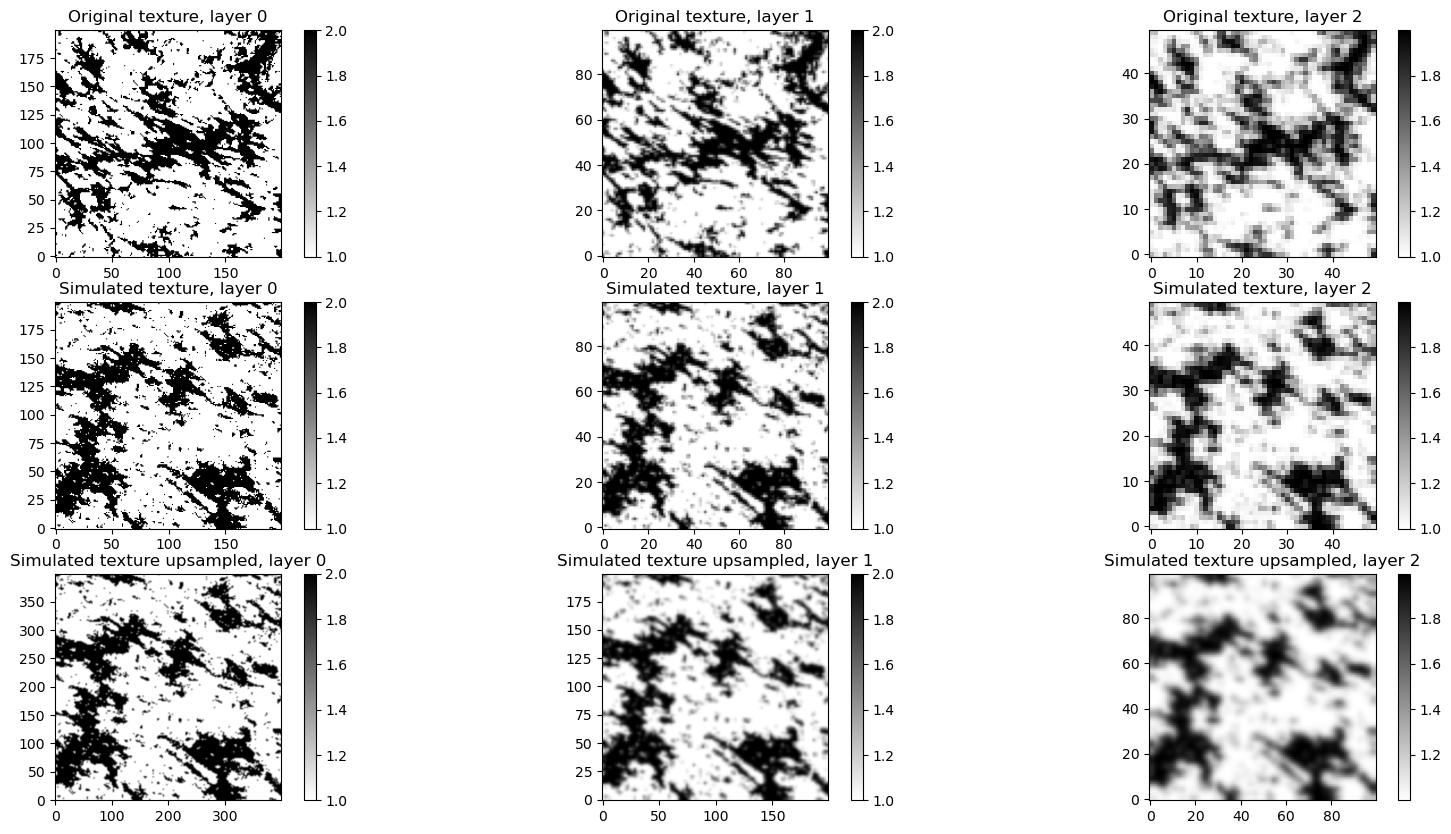

In [26]:
# Gaussian pyramid
from skimage.transform import pyramid_gaussian, pyramid_expand

pyramid = tuple(pyramid_gaussian(texture_, max_layer=2, downscale=2))
pyramid_sim = tuple(pyramid_gaussian(simulated_tex, max_layer=2, downscale=2))

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
for i, (layer, layer_sim) in enumerate(zip(pyramid, pyramid_sim)):
    fig.colorbar(axs[0, i].imshow(layer, cmap='gray_r', origin='lower'),
                 ax=axs[0, i])
    axs[0, i].set_title(f'Original texture, layer {i}')
    fig.colorbar(axs[1, i].imshow(layer_sim, cmap='gray_r', origin='lower'),
                 ax=axs[1, i])
    axs[1, i].set_title(f'Simulated texture, layer {i}')
    layer_sim_up = pyramid_expand(layer_sim, upscale=2)
    fig.colorbar(axs[2, i].imshow(layer_sim_up, cmap='gray_r', origin='lower'),
                 ax=axs[2, i])
    axs[2, i].set_title(f'Simulated texture upsampled, layer {i}')
plt.show()

100%|██████████| 10000/10000 [00:01<00:00, 8264.92it/s]


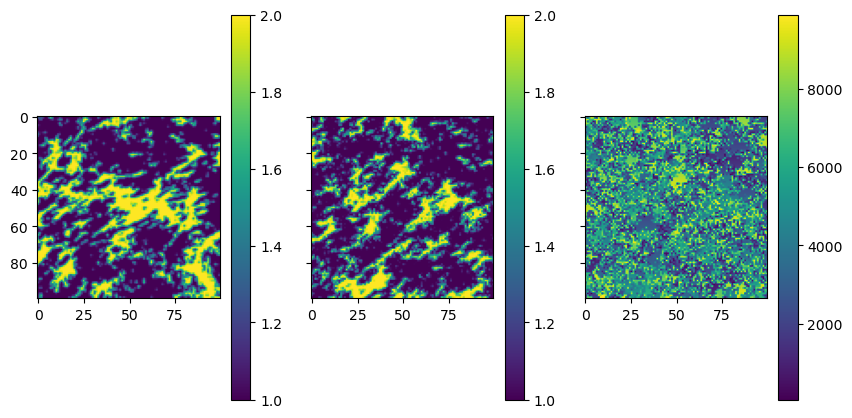

In [46]:
import bitis as bt

training_image = pyramid[1]

max_known_pixels = 10
max_template_size = 30
min_template_size = 3
num_of_candidates = 1
min_known_pixels = 1
use_tf = False

simulation_tex = np.zeros_like(training_image)
simulation = bt.Simulation()
simulation.path_builder = bt.RandomSimulationPathBuilder(simulation_tex)
simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                         max_known_pixels,
                                                         max_template_size,
                                                         min_template_size)
simulation.template_matching = bt.ContinuousVariableMatching(training_image,
                                                             num_of_candidates,
                                                             min_known_pixels,
                                                             use_tf)
simulated_tex = simulation.run()

fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
fig.colorbar(ax[0].imshow(training_image))
fig.colorbar(ax[1].imshow(simulated_tex))
fig.colorbar(ax[2].imshow(simulation._index_map))
plt.show()

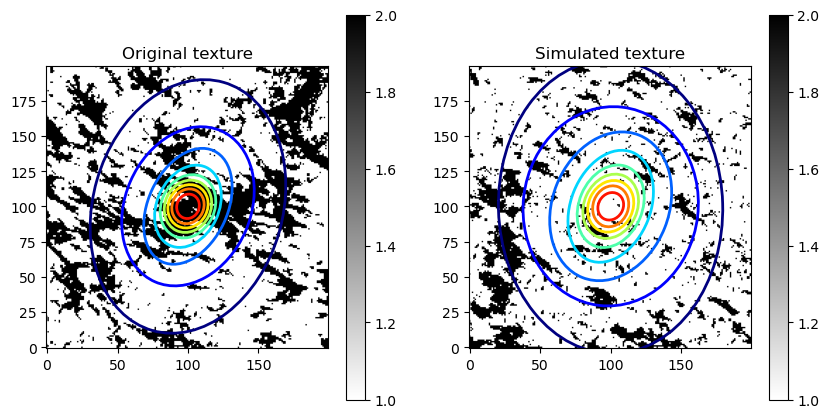

In [39]:
from scipy.ndimage import gaussian_filter
from skimage import measure
from matplotlib.patches import Ellipse


def calculate_power_spectrum(texture):
    texture_fft = np.fft.fftn(texture - texture.mean())
    texture_power = np.abs(texture_fft) ** 2
    texture_power = np.fft.fftshift(texture_power)
    return texture_power


def equivalent_ellipses(texture_power):
    ellipses = []
    for threshold in np.arange(0.1, 1.0, 0.1):
        texture_power = gaussian_filter(texture_power, sigma=4)
        sorted_idx = np.argsort(texture_power.ravel())
        cumsum = np.cumsum(texture_power.ravel()[sorted_idx])
        idx = sorted_idx[cumsum > cumsum[-1] * threshold]
        coords = np.unravel_index(idx, texture_power.shape)

        mask = np.zeros_like(texture_power, dtype=np.uint8)
        mask[tuple(coords)] = 1

        props = measure.regionprops(mask)
        short_axis = props[0].axis_minor_length
        long_axis = props[0].axis_major_length
        angle = props[0].orientation
        mean = props[0].centroid
        ellipses.append((mean, short_axis, long_axis, angle))
    return ellipses


tex_power = calculate_power_spectrum(texture)
sim_power = calculate_power_spectrum(simulated_tex)

sim_ellipses = equivalent_ellipses(sim_power)
tex_ellipses = equivalent_ellipses(tex_power)

cmap = plt.get_cmap('jet')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, tex, ellipses in zip(axs, [texture, simulated_tex],
                             [tex_ellipses, sim_ellipses]):
    cax = ax.imshow(tex, cmap='gray_r', origin='lower')
    # draw ellipses
    for i, (mean, w, h, angle) in enumerate(ellipses):
        ellipse = Ellipse(mean[::-1], w, h, angle=np.degrees(np.pi - angle),
                        fill=False, lw=2, edgecolor=cmap(i / len(ellipses)))
        ax.add_patch(ellipse)

    fig.colorbar(cax, ax=ax)
axs[0].set_title('Original texture')
axs[1].set_title('Simulated texture')
plt.show()

In [40]:
# Shannon entropy

def shannon_entropy(tex_power):
    tex_power /= tex_power.sum()
    return -np.sum(tex_power * np.log(tex_power)) / np.log(tex_power.size)


tex_entropy = shannon_entropy(tex_power)
sim_entropy = shannon_entropy(sim_power)

print(f"Original texture entropy: {tex_entropy:.2f}")
print(f"Simulated texture entropy: {sim_entropy:.2f}")

Original texture entropy: 0.78
Simulated texture entropy: 0.83


In [41]:
# Moran's I
from scipy.signal import convolve2d

def morans_i(texture):
    N = texture.size
    tex_mean = texture - texture.mean()
    weights = np.array([[1/np.sqrt(8), 1/np.sqrt(5), 1/2, 1/np.sqrt(5), 1/np.sqrt(8)],
                        [1/np.sqrt(5), 1/np.sqrt(2), 1, 1/np.sqrt(2), 1/np.sqrt(5)],
                        [1/2, 1, 0, 1, 1/2],
                        [1/np.sqrt(5), 1/np.sqrt(2), 1, 1/np.sqrt(2), 1/np.sqrt(5)],
                        [1/np.sqrt(8), 1/np.sqrt(5), 1/2, 1/np.sqrt(5), 1/np.sqrt(8)]])

    neighbors = convolve2d(texture, weights, mode='same', boundary='wrap')

    sum_num = np.sum(tex_mean * neighbors)
    sum_den = np.sum(tex_mean**2)
    W = np.sum(weights) * N
    return N / W * sum_num / sum_den

print(morans_i(texture))
print(morans_i(simulated_tex))

0.5907036000249118
0.4936728731183321
